# Modeling - Regression

What is it?
-  a SUPERVISED machine learning model used to predict a CONTINUOUS target variable

Why do we care?
- so we can build models to predict future continuous target variables

### Pipeline

Acquire
- get the data into pandas
- look at it
    - describe, info, head, shape
- understand what your data means
    - know what each column is
    - know what your target variable is

Wrangle
- clean the data
    - handle nulls
    - handle outliers
    - correct datatypes
- univariate analysis (looking at only one variable)
- encode variables -- Preprocessing
- split into train, validate/, test
- scale data (after train/validate/test split) -- Preprocessing
- document how your changing the data

Explore 
- use only train data!
    - use unscaled data
- establish relationships using multivariate analysis 
    - hypothesize
    - visualize
    - statistize
    - summarize
- feature engineering
    - when using RFE, use scaled data

Model 
- use scaled/encoded data
- split into X_variables and y_variables
    - X_train, y_train, X_validate, y_validate, X_test, y_test
- build models
    - make the thing 
    - fit the thing (on train)
    - use the thing 
- evaluate models on train and validate
- pick the best model and evaluate it on test

### Models today
- Ordinary Least Squares
- LASSO + LARS
- Polynomial Regression
- Generalized Linear Model

In [168]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Scenario

Continuing with attempting to predict final exam grade based on previous exam grades
    
    

## Wrangle

In [169]:
def wrangle_grades():
    '''
    read csv from url into df, clean df, and return the prepared df
    '''
    # Read csv file into pandas DataFrame.
    file = "https://gist.githubusercontent.com/ryanorsinger/\
14c8f919920e111f53c6d2c3a3af7e70/raw/07f6e8004fa171638d6d599cfbf0513f6f60b9e8/student_grades.csv"
    df = pd.read_csv(file)

    #replace blank space with null value
    df.exam3 = df.exam3.replace(' ', np.nan)
    
    #drop all nulls
    df = df.dropna()
    
    # Convert all columns to int64 data types.
    df = df.astype('int')

    # Perform a train, validate, test split
    train_validate, test = train_test_split(df, random_state=123, train_size=.8)
    train, validate = train_test_split(train_validate, random_state=123, train_size=.7)
    
    return train, validate, test

In [170]:
train, validate, test = wrangle_grades() 

In [171]:
train.head()

,student_id,exam1,exam2,exam3,final_grade
51,52,70,75,78,72
24,25,57,65,75,65
57,58,79,70,85,81
92,93,98,93,96,95
81,82,83,80,86,85


## Model - Regression Edition

Split into our X_train and y_train using our numeric data

In [172]:
X_train = train.drop(columns=['final_grade','student_id'])
X_train.head()

,exam1,exam2,exam3
51,70,75,78
24,57,65,75
57,79,70,85
92,98,93,96
81,83,80,86


In [173]:
X_validate = validate.drop(columns=['final_grade','student_id'])
X_test = test.drop(columns=['final_grade','student_id'])

In [174]:
y_train = train.final_grade
y_train.head()

51    72
24    65
57    81
92    95
81    85
Name: final_grade, dtype: int64

In [175]:
y_validate = validate.final_grade
y_test = test.final_grade

#### plot the target variable

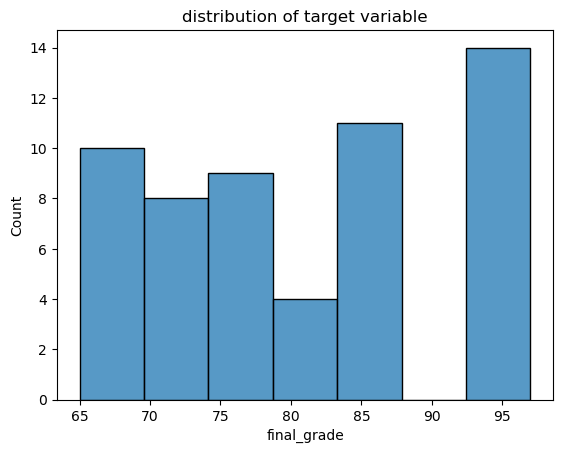

In [177]:
sns.histplot(y_train)
plt.title('distribution of target variable')
plt.show()

## Baseline

In [10]:
baseline = y_train.mean()
baseline

80.625

#### evaluate

In [58]:
def metrics_reg(y, yhat):
    """
    send in y_true, y_pred & returns RMSE, R2
    """
    rmse = mean_squared_error(y, yhat, squared=False)
    r2 = r2_score(y, yhat)
    return rmse, r2

In [59]:
#make an array to send into my mean_square_error function
baseline_array = np.repeat(baseline, len(train))
baseline_array[:5]

array([80.625, 80.625, 80.625, 80.625, 80.625])

In [60]:
rmse, r2 = metrics_reg(y_train, baseline_array)
rmse, r2

(10.410438614335956, 0.0)

In [61]:
metrics_df = pd.DataFrame(data=[
    {
        'model':'baseline',
        'rmse':rmse,
        'r2':r2
    }
    
])
metrics_df

,model,rmse,r2
0,baseline,10.410439,0.0


## Ordinary Least Squares (OLS)

OLS is our standard linear regression algorithm and is computed by minimizing the sum of squared differences in the linear model (residual) with the actual data points

In [62]:
#import
from sklearn.linear_model import LinearRegression

### simple linear regression + RFE

send in only one feature

In [63]:
from sklearn.feature_selection import RFE

#### find the best feature

In [64]:
#intial ML model
lr1 = LinearRegression()

#make it
rfe = RFE(lr1, n_features_to_select=1)

#fit it
rfe.fit(X_train, y_train)

#use it on train
X_train_rfe = rfe.transform(X_train)

#use it on validate
X_val_rfe = rfe.transform(X_validate)

In [65]:
print('selected top feature:', rfe.get_feature_names_out())

selected top feature: ['exam1']


#### build model from top feature

In [78]:
#fit the thing
lr1.fit(X_train_rfe, y_train)

#use the thing (make predictions)
pred_lr1 = lr1.predict(X_train_rfe)
pred_val_lr1 = lr1.predict(X_val_rfe)

In [79]:
pred_lr1[:10]

array([75.25871808, 65.36845673, 82.1058221 , 96.56081946, 85.14897944,
       85.14897944, 66.12924606, 91.99608345, 66.12924606, 86.67055811])

#### evaluate

In [80]:
#train
metrics_reg(y_train, pred_lr1)

(1.7338428599992761, 0.9722615995654157)

In [81]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_lr1)
rmse, r2

(2.081369873023788, 0.9595282086291942)

In [82]:
#add to my metrics df
metrics_df.loc[1] = ['ols_1', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,10.410439,0.000000
1,ols_1,2.081370,0.959528


### examine the model
   
$y = \beta_0 + \beta_i x_i$

**intercept** ($\beta_0$): Value we predict if x is 0. Depending on our x variables, this may not be valuable

**coefficients** ($\beta_i$): Define how our prediction changes as x changes. A one-unit increase in x causes our model to predict a coef unit change in y, holding all other independent variables constant

In [83]:
lr1.intercept_

22.0034646380959

In [84]:
lr1.coef_

array([0.76078933])

In [85]:
print(f'final_grade = {lr1.intercept_:.3} + {lr1.coef_[0]:.2}*exam1')

final_grade = 22.0 + 0.76*exam1


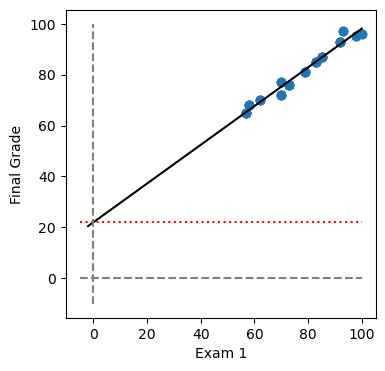

In [86]:
plt.figure(figsize=(4, 4))

plt.scatter(train.exam1, train.final_grade)

#build prediction line from intercept and slope
x_val = np.array([-2, 100]).reshape(-1, 1)
plt.plot(x_val, lr1.intercept_ + x_val*lr1.coef_[0], c='black')

#intercept line
plt.hlines(22, -5, 100, ls=':', color='red')  

#(0,0) axis
plt.hlines(0, -5, 100, ls='--', color='grey')
plt.vlines(0, -10, 100, ls='--', color='grey')
 
plt.xlabel('Exam 1')
plt.ylabel('Final Grade')
plt.show()

#### Intrepretation

For every 1 [unit] increase in [feature], we predict a [# unit] increase in [target_variable]

In [87]:
print(f'For every 1 point increase in Exam 1, we predict a {lr1.coef_[0]:.2f} point increase in Final Grade')

For every 1 point increase in Exam 1, we predict a 0.76 point increase in Final Grade


### Multiple Regression

$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3$

#### model using OLS

In [89]:
#make it
lr2 = LinearRegression()

#fit it on our RFE features
lr2.fit(X_train, y_train)

#use it (make predictions)
pred_lr2 = lr2.predict(X_train)

#use it on validate
pred_val_lr2 = lr2.predict(X_validate)

In [90]:
pred_lr2[:10]

array([74.98203162, 66.22585074, 82.32765701, 96.67272164, 84.9902655 ,
       84.9902655 , 65.63316023, 92.47730856, 65.63316023, 86.45767434])

#### evaluate

In [91]:
#train 
metrics_reg(y_train, pred_lr2)

(1.5942036131598638, 0.9765496395325735)

In [92]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_lr2)
rmse, r2

(1.8945695408484302, 0.9664667998401473)

In [93]:
#add to my metrics df
metrics_df.loc[2] = ['ols', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,10.410439,0.000000
1,ols_1,2.081370,0.959528
2,ols,1.894570,0.966467


## LassoLars

LASSO = Least Absolute Shrinkage and Selection Operator

LARS = Least Angle Regression

- Performs intrinsic feature selection and noise reduction to avoid overfitting
- The most important hyperparameter is alpha
    - alpha determines the degree of regularization applied to the model
    - The lowest alpha is zero, and this represents no regularization (identical to OLS)
    - There is no limit to alpha, but as it rises, it will reach a point where performance no longer changes (often because you've regularized all of your coefficients to zero
    - Generally speaking, the higher the alpha, the lower your risk for overfitting
    - alpha = 1.0 is a good place to start

In [97]:
#import
from sklearn.linear_model import LassoLars

#### alpha = 0, identical to OLS

In [98]:
#make it
lars = LassoLars(alpha=0)

#fit it
lars.fit(X_train, y_train)

#use it
pred_lars = lars.predict(X_train)

In [99]:
pd.Series(lars.coef_, index=lars.feature_names_in_)

exam1    0.623032
exam2   -0.007266
exam3    0.243144
dtype: float64

In [100]:
lr2.coef_

array([ 0.62303151, -0.00726619,  0.2431444 ])

#### alpha = 1 

In [102]:
#make it
lars = LassoLars(alpha=1)

#fit it
lars.fit(X_train, y_train)

#use it
pred_lars = lars.predict(X_train)
pred_val_lars = lars.predict(X_validate)

#### evaluate

In [103]:
#train
metrics_reg(y_train, pred_lars)

(1.6026392529668225, 0.9763008103790245)

In [104]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_lars)
rmse, r2

(1.9223645252386812, 0.9654756598664411)

In [105]:
#add to my metrics df
metrics_df.loc[3] = ['lars', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,10.410439,0.000000
1,ols_1,2.081370,0.959528
2,ols,1.894570,0.966467
3,lars,1.922365,0.965476


## Polynomial Regression

$y = \beta_0 + \beta_i x + \beta_k x^k$

We can introduce higher powers of our independent variables, meaning the model can predict a curve instead of a line 

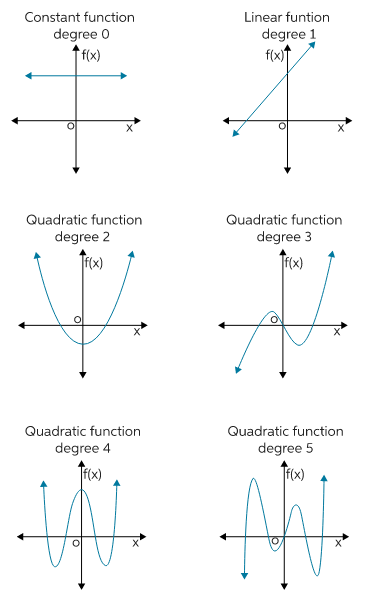

However, the more curves you introduce, the more likely your model is to be overfit!

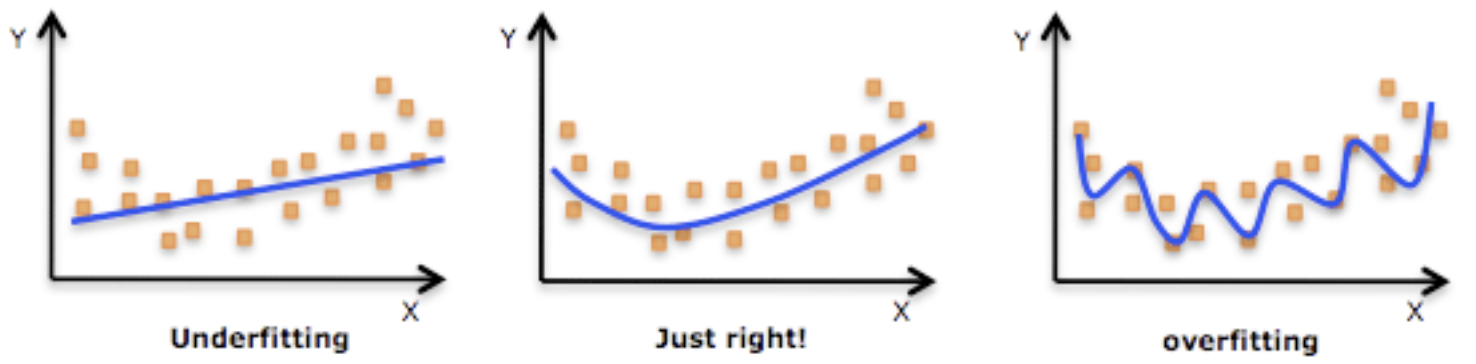

#### process
1. create new features based on degrees
2. fit on a linear regression model

In [106]:
#import
from sklearn.preprocessing import PolynomialFeatures

#### create new features based on degrees

In [107]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

#### fit on a linear regression model

In [109]:
#make it
pr = LinearRegression()

#fit it
pr.fit(X_train_degree2, y_train)

#use it
pred_pr = pr.predict(X_train_degree2)
pred_val_pr = pr.predict(X_validate_degree2)

#### evaluate

In [110]:
#train
metrics_reg(y_train, pred_pr)

(0.7819125551988452, 0.9943587114019328)

In [111]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_pr)
rmse, r2

(0.7481555087919325, 0.9947707710637546)

In [112]:
#add to my metrics df
metrics_df.loc[4] = ['poly_2', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,10.410439,0.000000
1,ols_1,2.081370,0.959528
2,ols,1.894570,0.966467
3,lars,1.922365,0.965476
4,poly_2,0.748156,0.994771


## Generalized Linear Model (GLM)

The most flexible regression algorithm, the GLM allows for different distributions, beyond just the Normal Distribution for OLS (and other models based on OLS, like LASSO). We will use the TweedieRegressor method to create a GLM using sklearn.

About power:

    power = 0: Normal Distribution
    power = 1: Poisson Distribution
    power = (1,2): Compound Distribution
    power = 2: Gamma Distribution
    power = 3: Inverse Gaussian Distribution

In [114]:
from sklearn.linear_model import TweedieRegressor

#make it
glm = TweedieRegressor(power=1, alpha=0)

#fit it
glm.fit(X_train, y_train)

#use it
pred_glm = glm.predict(X_train)
pred_val_glm = glm.predict(X_validate)

#### evaluate

In [115]:
#train
metrics_reg(y_train, pred_glm)

(1.6245689260308507, 0.9756477984975096)

In [116]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_glm)
rmse, r2

(1.8822226431217641, 0.9669024469517911)

In [117]:
metrics_df.loc[5] = ['glm',rmse,r2]
metrics_df

,model,rmse,r2
0,baseline,10.410439,0.000000
1,ols_1,2.081370,0.959528
2,ols,1.894570,0.966467
3,lars,1.922365,0.965476
4,poly_2,0.748156,0.994771
5,glm,1.882223,0.966902


### Evaluate on Best Model

In [120]:
#use it
pred_test = pr.predict(X_test_degree2)
pred_test

array([76.74470484, 76.74470484, 95.94592931, 96.33088858, 95.94592931,
       95.94592931, 81.00952165, 95.94592931, 93.73398954, 96.33088858,
       73.05379883, 85.21471928, 95.1672249 , 67.42977776, 95.94592931,
       81.00952165, 73.05379883, 95.1672249 , 93.73398954, 95.94592931,
       65.65281464])

In [121]:
rmse, r2 = metrics_reg(y_test, pred_test)
rmse, r2

(0.6300580385611962, 0.996601468566695)

#### plot actuals vs predicted

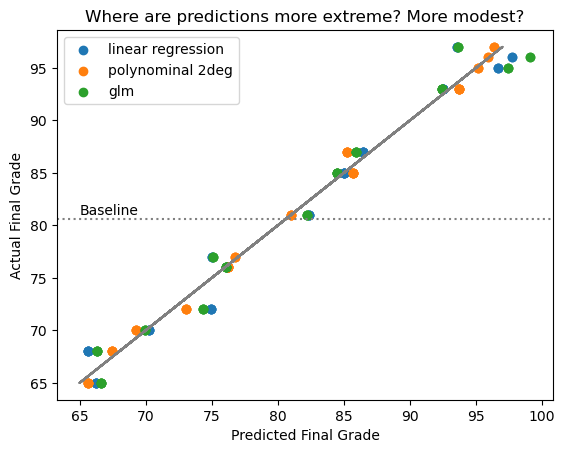

In [202]:
plt.scatter(pred_lr2, y_train, label='linear regression')
plt.scatter(pred_pr, y_train, label='polynominal 2deg')
plt.scatter(pred_glm, y_train, label='glm')
plt.plot(y_train, y_train, label='_nolegend_', color='grey')

plt.axhline(baseline, ls=':', color='grey')
plt.annotate("Baseline", (65, 81))

plt.title("Where are predictions more extreme? More modest?")
plt.ylabel("Actual Final Grade")
plt.xlabel("Predicted Final Grade")
plt.legend()

plt.show()

#### plotting the residuals

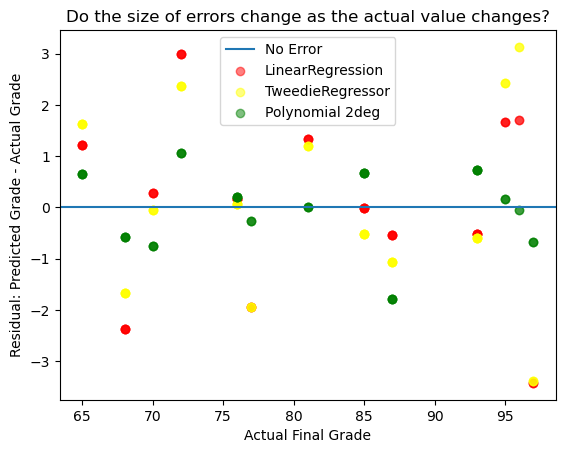

In [217]:
plt.axhline(label="No Error")

plt.scatter(y_train, pred_lr2 - y_train, alpha=.5, color="red", label="LinearRegression")
plt.scatter(y_train, pred_glm - y_train, alpha=.5, color="yellow", label="TweedieRegressor")
plt.scatter(y_train, pred_pr - y_train, alpha=.5, color="green", label="Polynomial 2deg ")

plt.legend()
plt.title("Do the size of errors change as the actual value changes?")
plt.xlabel("Actual Final Grade")
plt.ylabel("Residual: Predicted Grade - Actual Grade")

plt.show()

#### histogram of actual and predicted values

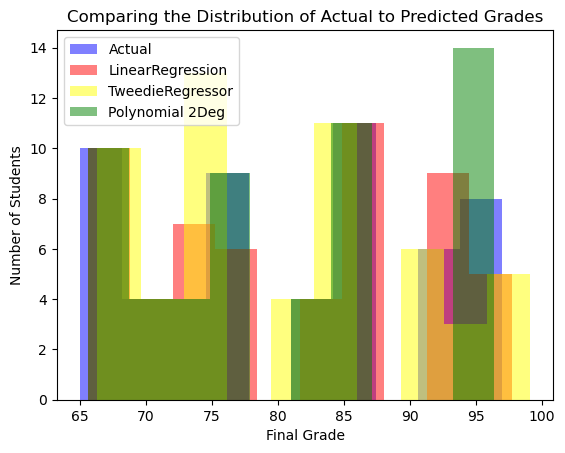

In [218]:
plt.hist(y_train, color='blue', alpha=.5, label="Actual")
plt.hist(pred_lr2, color='red', alpha=.5, label="LinearRegression")
plt.hist(pred_glm, color='yellow', alpha=.5, label="TweedieRegressor")
plt.hist(pred_pr, color='green', alpha=.5, label="Polynomial 2Deg")

plt.xlabel("Final Grade")
plt.ylabel("Number of Students")
plt.title("Comparing the Distribution of Actual to Predicted Grades")
plt.legend()
plt.show()

### Recap

- look at the distribution of your target variable
- for normally distributed target variable
    - OLS
    - LassoLars
        - start with alpha=1
    - GLM
        - power=0
- for polynomial relationships
    - polynomial regression
        - calculate poly features then use LR
- for poisson, gamma, or inverse guassian distributions
    - GLM
        - power = 1: Poisson Distribution
        - power = 2: Gamma Distribution
        - power = 3: Inverse Gaussian Distribution